In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from skimage import io
import cv2 as cv
import os
import DarkArtefactRemoval as dca
import dullrazor as dr
import segmentation_and_preprocessing as sp
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
import csv

# Loading Data

In [2]:
# Répertoire contenant les images
image_dir_train = 'Train/Train/'
image_dir_test = 'Test/Test/'

Train_path = image_dir_train

import glob
images_train = glob.glob(Train_path + '/*[0-9].jpg')
mask_img_train = glob.glob(Train_path + '/*seg.png')

images_with_mask = [ Train_path + mask_img_train[i].split('/')[-1].split('_seg')[0] + '.jpg' for i in range(len(mask_img_train))]
images_test = glob.glob(image_dir_test + '/*[0-9].jpg')
mask_img_test = glob.glob(image_dir_test + '/*seg.png')

#Lire le csv metadataTrain et metadataTest
metadataTrain = pd.read_csv('metadataTrain.csv')
metadataTest = pd.read_csv('metadataTest.csv')



In [3]:
# Checking if the number of images is right 
print('There are', len(images_train),  'train images')
print('There are', len(images_with_mask),  'train images with mask')
print('There are', len(mask_img_train),  'train masks')
print('There are', len(images_test),  'test images')
print('There are', len(mask_img_test),  'test masks')

There are 18998 train images
There are 1945 train images with mask
There are 1945 train masks
There are 6333 test images
There are 648 test masks


### Compute the segmentation mask for all the 20 000 images of the training set

In [4]:
sp.compute_and_save_segmented_lesions(images_train, 'output_masks_train_set')

  0%|          | 0/18998 [00:00<?, ?it/s]

  1%|          | 222/18998 [00:26<28:08, 11.12it/s]  /Users/matthieu.kaeppelin/Documents/4-TélécomParis/1-Cours/IMA/IMA-205/ima205-challenge-2024/segmentation_and_preprocessing.py:206: RuntimeWarning: invalid value encountered in divide
  mask_pred_normalized = np.array(mask_pred.astype(float) / mask_pred.max()).astype(int)
/Users/matthieu.kaeppelin/Documents/4-TélécomParis/1-Cours/IMA/IMA-205/ima205-challenge-2024/segmentation_and_preprocessing.py:206: RuntimeWarning: invalid value encountered in cast
  mask_pred_normalized = np.array(mask_pred.astype(float) / mask_pred.max()).astype(int)
  2%|▏         | 342/18998 [00:40<37:12,  8.36it/s]  


KeyboardInterrupt: 

# CNN

### Préparation des données

- Images carrées de 256x256
- Normalisation des images
- Augmentation des données

### Prepare data for CNN

In [ ]:
X_train = glob.glob('output_masks_train_set/*.png')
X_train_names = [os.path.basename(x).split('.jpg_pred_mask.png')[0] for x in X_train]

# Get the names and classes as pandas Series
names_series = metadataTrain["ID"].loc[metadataTrain["ID"].isin(X_train_names)]
classes_series = metadataTrain["CLASS"].loc[metadataTrain["ID"].isin(X_train_names)]

# Convert the pandas Series to lists
names_list = names_series.tolist()
classes_list = classes_series.tolist()

X_train_ordered = []
X_train_ordered_names = []
for i in range(0, len(names_list)):
    for j in range(0, len(X_train_names)):
        if names_list[i] in X_train_names[j]:
            X_train_ordered.append(X_train[j])
            X_train_ordered_names.append(X_train_names[j])

##### Train test split

In [ ]:
X_train = [io.imread(x) for x in X_train_ordered]
X_train = np.array(X_train)
y_train = classes_list
y_train = np.array(y_train)

#Créer la validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=50)

In [ ]:

# Créer le modèle CNN
def create_cnn(input_shape, num_classes=8):
    model = models.Sequential()

    # Couche de convolution 1
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))

    # Couche de convolution 2
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    # Couche de convolution 3
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))

    # Flatten les features en un vecteur
    model.add(layers.Flatten())

    # Couches fully connected
    model.add(layers.Dense(64, activation='relu'))

    # Couche de sortie
    model.add(layers.Dense(num_classes, activation='softmax'))  # softmax pour la classification multiclasse

    return model


# Définir la taille d'entrée
input_shape = (256, 256, 3)

# Créer le modèle CNN
model = create_cnn(input_shape)

# Afficher un résumé du modèle
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 64)        36928     
                                                                 
 flatten (Flatten)           (None, 230400)            0

In [ ]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',  # Adapté à la classification avec plusieurs classes
              metrics=['accuracy'])

# Entraînement du modèle
history = model.fit(X_train, y_train, epochs=10, 
                    validation_data=(X_val, y_val))

# Affichage des courbes d'apprentissage
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

Epoch 1/10
49/49 [==============================] - 26s 525ms/step - loss: 5.2930 - accuracy: 0.6279 - val_loss: 0.9253 - val_accuracy: 0.6915
Epoch 2/10
 3/49 [>.............................] - ETA: 23s - loss: 0.3271 - accuracy: 0.9375

KeyboardInterrupt: 

### Heatmap

13/13 [==============================] - 2s 161ms/step
(389, 8)


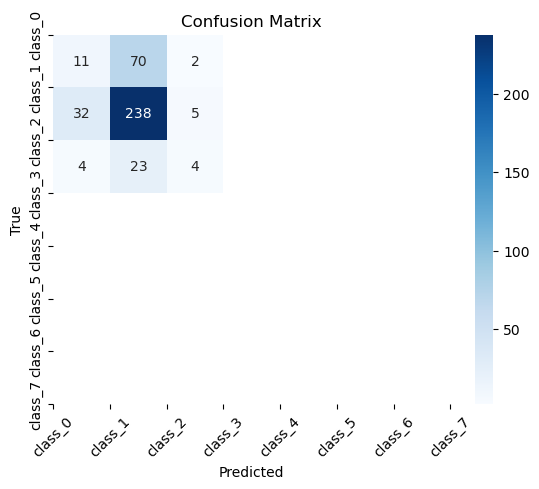

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predict the classes for the validation set
y_pred = model.predict(X_val)
print(y_pred.shape)
y_pred = [np.argmax(y_pred[i]) for i in range(0, len(y_pred))]


# Create a confusion matrix
cm = confusion_matrix(y_val, y_pred)

# Create a heatmap from the confusion matrix
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')

# Labels, title and ticks
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.xticks(range(8))
plt.yticks(range(8))

# Add class names to the x and y axis labels
class_names = ['class_0', 'class_1', 'class_2', 'class_3', 'class_4', 'class_5', 'class_6', 'class_7'] # replace with your class names
plt.xticks(range(8), class_names, rotation=45)
plt.yticks(range(8), class_names)

plt.show()


## Préparation de la detection

### Prepare data for predicting the test set

In [ ]:
X_test = glob.glob('output_masks_test_set/*.png')
X_test_names = [os.path.basename(x).split('.jpg_pred_mask.png')[0] for x in X_test]

X_test = [io.imread(x) for x in X_test]
X_test = np.array(X_test)
print(X_test.shape)

(6333, 256, 256, 3)


In [ ]:
predicted_classes = model.predict(X_test)

NameError: name 'model' is not defined

In [ ]:
print(predicted_classes.shape)
print(predicted_classes)

predicted_classes_final = [np.argmax(predicted_classes[i]) for i in range(0, len(predicted_classes))]

print(predicted_classes_final)

NameError: name 'predicted_classes' is not defined

Ecrire les résultats predicted class dans un fichier csv de 2 colonnes avec 1 colonne avec le nom correspondant à la classe et 1 colonne correspondant à la classe prédite. Le séparateur est une virgule

In [ ]:
# Open the CSV file for writing
with open('SampleSubmission2.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    # Write the header row
    writer.writerow(['ID', 'CLASS'])

    # Write the predicted classes and image filenames to the CSV file
    for i in range(len(predicted_classes)):
        writer.writerow([X_test_names[i], predicted_classes_final[i]])